# Projeto 2 - Classificador Automático de Sentimento

### Proposta:

Você foi contratado por uma empresa parar analisar como os clientes estão reagindo a um determinado produto no Twitter. A empresa deseja que você crie um programa que irá analisar as mensagens disponíveis e classificará como "relevante" ou "irrelevante". Com isso ela deseja que mensagens negativas, que denigrem o nome do produto, ou que mereçam destaque, disparem um foco de atenção da área de marketing.<br /><br />
Como aluno de Ciência dos Dados, você lembrou do Teorema de Bayes, mais especificamente do Classificador Naive-Bayes, que é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser relevante dadas as palavras em seu conteúdo.<br /><br />
Para realizar o MVP (*minimum viable product*) do projeto, você precisa implementar uma versão do classificador que "aprende" o que é relevante com uma base de treinamento e compara a performance dos resultados com uma base de testes.<br /><br />
Após validado, o seu protótipo poderá também capturar e classificar automaticamente as mensagens da plataforma.

### Produto escolhido: Uber

___

## Parte I - Adquirindo a Base de Dados


#### Importação de bibliotecas

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import math as math
from scipy import stats
import matplotlib.pyplot as plt
from collections import OrderedDict

##### Abertura de tabela de treinamento e busca de probabilidades por nível de relevância
Exemplo: P(Relevante)

In [2]:
#Encontrando probabilidades por nível de relevância
treinamento = pd.read_excel('tweets_uber_201809042131.xlsx') 
treinamento.Relevância = treinamento.Relevância.astype('category')
treinamento.Relevância.cat.categories = ('Muito Irrelevante', 'Irrelevante','Neutro','Relevante','Muito Relevante')
porcentagem = treinamento.Relevância.value_counts(True)
P_Muito_Irrelevante=porcentagem[0]
P_Irrelevante=porcentagem[1]
P_Muito_Relevante=porcentagem[2]
P_Relevante=porcentagem[3]
P_Neutro=porcentagem[4]

##### Limpeza de "stopwords" e agrupamento de palavras semelhantes - Treinamento
Além de removermos símbolos isolados e palavras vagas, nessa seção propomos a limpeza de palavras que possuam '@', uma vez que retratam simplesmente o nome de usuário dos autores de cada tweet. No entanto, consideramos a excessão do '@uber' e '@uber_support', por geralmente estarem relacionados a pedidos de ajuda ou reclamações diretas à empresa (e logo são muito relevantes), ainda deixamos no banco de dados o '@lyft' por tratar-se de um concorrente cujas citações em tweets removem a comparações e podem consequentemente depredar a reputação do aplicativo Uber. 
Ademais, removemos da base as palavras contendo 'https' por tratarem de links cuja natureza do conteúdo é desconhecida, e palavras contendo '...' por se tratarem daquelas cuja terminação não conhecemos (vieram interrompidas no momento do download de tweets).

In [3]:
listona= []
unwanted = ["enter",":","'",'(',')',',','a','an','and','the','did']

for linha in treinamento.Treinamento:
    elemento=[]
    elemento.append(linha)
    listinha= linha.split()
    for palavra in listinha:
        if palavra != '@uber' and palavra != '@uber_support' and palavra !='@lyft':     
            if '@' in palavra or 'http' in palavra or '...' in palavra:
                unwanted.append(palavra)
        if palavra[-1]==',' or palavra[-1]=='!' or palavra[-1]=='?' or palavra[-1]=='.':
            palavra = palavra[:-1]
            
    for palavra in unwanted:  
        if palavra in listinha:
            listinha.remove(palavra)   
            
    elemento.append(listinha)
    listona.append(elemento)

#### Gerando probabilidades condionais da base de treinamento
Exemplo: P(palavra|Relevante)


In [4]:
dicionario_Muito_Irrelevante={}
dicionario_Irrelevante={}
dicionario_Muito_Relevante={}
dicionario_Relevante={}
dicionario_Neutro={}

for linha in treinamento[treinamento.Relevância=="Muito Irrelevante"].Treinamento:
    dicionario_Muito_Irrelevante[linha]= linha.split()       
    dicionario_Muito_Irrelevante[linha]= list(set(dicionario_Muito_Irrelevante[linha]).difference(set(unwanted)))
    
    
total_palavras_Muito_Irrelevante=[]
for lista in dicionario_Muito_Irrelevante.values():
    for palavra in lista:
        total_palavras_Muito_Irrelevante.append(palavra)
        
        probabilidade_Muito_Irrelevante={}
        for palavra in total_palavras_Muito_Irrelevante:
            probabilidade_Muito_Irrelevante[palavra]=(total_palavras_Muito_Irrelevante.count(palavra)/len(total_palavras_Muito_Irrelevante))
    

for linha in treinamento[treinamento.Relevância=="Irrelevante"].Treinamento:
    dicionario_Irrelevante[linha]= linha.split()       
    dicionario_Irrelevante[linha]= list(set(dicionario_Irrelevante[linha]).difference(set(unwanted)))
        
total_palavras_Irrelevante=[]
for lista in dicionario_Irrelevante.values():
    for palavra in lista:
        total_palavras_Irrelevante.append(palavra)
        
        probabilidade_Irrelevante={}
        for palavra in total_palavras_Irrelevante:
            probabilidade_Irrelevante[palavra]= (total_palavras_Irrelevante.count(palavra)/len(total_palavras_Irrelevante))

    
for linha in treinamento[treinamento.Relevância=="Muito Relevante"].Treinamento:
    dicionario_Muito_Relevante[linha]= linha.split()       
    dicionario_Muito_Relevante[linha]= list(set(dicionario_Muito_Relevante[linha]).difference(set(unwanted)))
        
total_palavras_Muito_Relevante=[]
for lista in dicionario_Muito_Relevante.values():
    for palavra in lista:
        total_palavras_Muito_Relevante.append(palavra)
        
        probabilidade_Muito_Relevante={}
        for palavra in total_palavras_Muito_Relevante:
            probabilidade_Muito_Relevante[palavra]= (total_palavras_Muito_Relevante.count(palavra)/len(total_palavras_Muito_Relevante))    
    
for linha in treinamento[treinamento.Relevância=="Relevante"].Treinamento:
    dicionario_Relevante[linha]= linha.split()       
    dicionario_Relevante[linha]= list(set(dicionario_Relevante[linha]).difference(set(unwanted)))
        
total_palavras_Relevante=[]
for lista in dicionario_Relevante.values():
    for palavra in lista:
        total_palavras_Relevante.append(palavra)
        
        probabilidade_Relevante={}
        for palavra in total_palavras_Relevante:
            probabilidade_Relevante[palavra]= (total_palavras_Relevante.count(palavra)/len(total_palavras_Relevante))
      
    
for linha in treinamento[treinamento.Relevância=="Neutro"].Treinamento:
    dicionario_Neutro[linha]= linha.split()       
    dicionario_Neutro[linha]= list(set(dicionario_Neutro[linha]).difference(set(unwanted)))
        
total_palavras_Neutro=[]
for lista in dicionario_Neutro.values():
    for palavra in lista:
        total_palavras_Neutro.append(palavra)

        probabilidade_Neutro={}
        for palavra in total_palavras_Neutro:
            probabilidade_Neutro[palavra]= (total_palavras_Neutro.count(palavra)/len(total_palavras_Neutro))   


#### Abertura da tabela de Teste

In [5]:
teste = pd.read_excel('tweets_uber_201809042131.xlsx',sheet_name='Teste') 

##### Limpeza de "stopwords" e agrupamento de palavras semelhantes - Teste

In [6]:
listona_teste= []
unwanted = ["enter",":","'",'(',')',',','a','an','and','the','did']

for linha in teste.Teste:
    elemento=[]
    elemento.append(linha)
    listinha= linha.split()
    for palavra in listinha:
        if palavra != '@uber' and palavra != '@uber_support' and palavra != "@lyft":     
            if '@' in palavra or 'http' in palavra or '...' in palavra:
                unwanted.append(palavra)
        if palavra[-1]==',' or palavra[-1]=='!' or palavra[-1]=='?' or palavra[-1]=='.':
            palavra = palavra[:-1]
            
    for palavra in unwanted:  
        if palavra in listinha:
            listinha.remove(palavra)   
            
    elemento.append(listinha)
    listona_teste.append(elemento)

## Parte 2 - Aplicação do classificador Naive Bayes com o auxílio do 'Laplace smoothing'


### Aplicação na lista de Treinamento
Com o intuito de checar a credibilidade de nosso programa, rodamos o classificador na própria tabela de treinamento, com a intenção de obter um alto índice de compatibilidade entre os valores previstos e os adquiridos.

In [7]:
quantidade_de_palavras_no_tweet={}
listafinal =[]

for listinha in listona: #lendo as linhas
    
    prob_tweet=[]

    p_mi_total = 1
    p_i_total = 1
    p_n_total = 1
    p_r_total = 1
    p_mr_total = 1
          

    for palavra in listinha[1]: #lendo as palavras
        quantidade_de_palavras_no_tweet[palavra]=len(listinha)
        
        variavel=1
        while variavel<=5:

            if variavel==1:
                if palavra in probabilidade_Muito_Irrelevante:
                    p_mi = ((probabilidade_Muito_Irrelevante[palavra]+1)/(quantidade_de_palavras_no_tweet[palavra]))
                    p_mi_total*=p_mi
                else:
                    p_mi = 1/(len(total_palavras_Muito_Irrelevante)+quantidade_de_palavras_no_tweet[palavra])
                    p_mi_total*=p_mi
                variavel+=1

            elif variavel==2:
                if palavra in probabilidade_Irrelevante:
                    p_i = ((probabilidade_Irrelevante[palavra]+1)/(quantidade_de_palavras_no_tweet[palavra]))
                    p_i_total*=p_i
                else:
                    p_i = 1/(len(total_palavras_Irrelevante)+quantidade_de_palavras_no_tweet[palavra])
                    p_i_total*=p_i
                variavel+=1

            elif variavel==3:
                if palavra in probabilidade_Neutro:
                    p_n = ((probabilidade_Neutro[palavra]+1)/(quantidade_de_palavras_no_tweet[palavra]))
                    p_n_total*=p_n
                else:
                    p_n = 1/(len(total_palavras_Neutro)+quantidade_de_palavras_no_tweet[palavra])
                    p_n_total*=p_n
                variavel+=1

            elif variavel==4:
                if palavra in probabilidade_Relevante:
                    p_r = ((probabilidade_Relevante[palavra]+1)/(quantidade_de_palavras_no_tweet[palavra]))
                    p_r_total*=p_r
                else:
                    p_r = 1/(len(total_palavras_Relevante)+quantidade_de_palavras_no_tweet[palavra])
                    p_r_total*=p_r
                variavel+=1

            elif variavel==5:
                if palavra in probabilidade_Muito_Relevante:
                    p_mr = ((probabilidade_Muito_Relevante[palavra]+1)/(quantidade_de_palavras_no_tweet[palavra]))
                    p_mr_total*=p_mr
                else:
                    p_mr = 1/(len(total_palavras_Muito_Relevante)+quantidade_de_palavras_no_tweet[palavra])
                    p_mr_total*=p_mr
                variavel+=1
        
    prob_tweet.append(p_mi_total*P_Muito_Irrelevante)
    prob_tweet.append(p_i_total*P_Irrelevante)
    prob_tweet.append(p_n_total*P_Neutro)
    prob_tweet.append(p_r_total*P_Muito_Irrelevante)
    prob_tweet.append(p_mr_total*P_Muito_Relevante)
    

    if prob_tweet[0]>prob_tweet[1] and prob_tweet[0]>prob_tweet[2] and prob_tweet[0]>prob_tweet[3] and prob_tweet[0]>prob_tweet[4]:
        listafinal.append(1)
    elif prob_tweet[1]>prob_tweet[0] and prob_tweet[1]>prob_tweet[2] and prob_tweet[1]>prob_tweet[3] and prob_tweet[1]>prob_tweet[4]:
        listafinal.append(2)
    elif prob_tweet[2]>prob_tweet[0] and prob_tweet[2]>prob_tweet[1] and prob_tweet[2]>prob_tweet[3] and prob_tweet[2]>prob_tweet[4]:
        listafinal.append(3)
    elif prob_tweet[3]>prob_tweet[0] and prob_tweet[3]>prob_tweet[1] and prob_tweet[3]>prob_tweet[2] and prob_tweet[3]>prob_tweet[4]:
        listafinal.append(4)
    else:
        listafinal.append(5)


In [8]:
treinamento['Segundo Classifier'] = listafinal
treinamento.Relevância.cat.categories = ('1', '2','3','4','5')

##### Tabela de comparação (Treinamento)

In [9]:
treinamento[['Treinamento','Segundo Classifier','Relevância']]

,Treinamento,Segundo Classifier,Relevância
0,@allthingscivil @ladylawyerdiary how about ube...,1,1
1,@anuragarora_ did anyone write engg blog on ub...,1,1
2,@cloeh_ uber is amazing,2,3
3,@clubcarmenxxx i can be your uber/backdoorman😁😁,1,1
4,@deetsbydre uber eats and deliveroo are the de...,2,2
5,@eriitrea91 @ri_kh @uber @lyft 😂 smart move i’...,4,4
6,@gabrielnu1 uber,4,1
7,@generocity @bcgp #safemuch ? cap &amp; regula...,2,2
8,@hannah_litteer uber over here to get ur ass beat,1,1
9,"@issamsayadi here to help, issam! in order to ...",1,1


##### Índice de compatibilidade - Treinamento

In [10]:
lista_relevancia= treinamento['Relevância'].tolist()
lista_adquirida= treinamento["Segundo Classifier"].tolist()
contagem=0

for i, elemento in enumerate(lista_relevancia):
    elemento=int(elemento)
    if elemento == lista_adquirida[i]:
        contagem+=1
        
probabilidade_de_acertos=contagem/(len(lista_relevancia))
print("Os resultados obtidos pelo nosso programa concordam em ",probabilidade_de_acertos*100,"% das vezes com as previsões." )

Os resultados obtidos pelo nosso programa concordam em  97.33333333333334 % das vezes com as previsões.


### Aplicação na lista de Teste

In [11]:
quantidade_de_palavras_no_tweet={}
listafinal_teste =[]

for listinha in listona_teste: #lendo as linhas
    
    prob_tweet=[]

    p_mi_total = 1
    p_i_total = 1
    p_n_total = 1
    p_r_total = 1
    p_mr_total = 1
          

    for palavra in listinha[1]: #lendo as palavras
        quantidade_de_palavras_no_tweet[palavra]=len(listinha)
        
        variavel=1
        while variavel<=5:

            if variavel==1:
                if palavra in probabilidade_Muito_Irrelevante:
                    p_mi = ((probabilidade_Muito_Irrelevante[palavra]+1)/(quantidade_de_palavras_no_tweet[palavra]))
                    p_mi_total*=p_mi
                else:
                    p_mi = 1/(len(total_palavras_Muito_Irrelevante)+quantidade_de_palavras_no_tweet[palavra])
                    p_mi_total*=p_mi
                variavel+=1

            elif variavel==2:
                if palavra in probabilidade_Irrelevante:
                    p_i = ((probabilidade_Irrelevante[palavra]+1)/(quantidade_de_palavras_no_tweet[palavra]))
                    p_i_total*=p_i
                else:
                    p_i = 1/(len(total_palavras_Irrelevante)+quantidade_de_palavras_no_tweet[palavra])
                    p_i_total*=p_i
                variavel+=1

            elif variavel==3:
                if palavra in probabilidade_Neutro:
                    p_n = ((probabilidade_Neutro[palavra]+1)/(quantidade_de_palavras_no_tweet[palavra]))
                    p_n_total*=p_n
                else:
                    p_n = 1/(len(total_palavras_Neutro)+quantidade_de_palavras_no_tweet[palavra])
                    p_n_total*=p_n
                variavel+=1

            elif variavel==4:
                if palavra in probabilidade_Relevante:
                    p_r = ((probabilidade_Relevante[palavra]+1)/(quantidade_de_palavras_no_tweet[palavra]))
                    p_r_total*=p_r
                else:
                    p_r = 1/(len(total_palavras_Relevante)+quantidade_de_palavras_no_tweet[palavra])
                    p_r_total*=p_r
                variavel+=1

            elif variavel==5:
                if palavra in probabilidade_Muito_Relevante:
                    p_mr = ((probabilidade_Muito_Relevante[palavra]+1)/(quantidade_de_palavras_no_tweet[palavra]))
                    p_mr_total*=p_mr
                else:
                    p_mr = 1/(len(total_palavras_Muito_Relevante)+quantidade_de_palavras_no_tweet[palavra])
                    p_mr_total*=p_mr
                variavel+=1
        
    prob_tweet.append(p_mi_total*P_Muito_Irrelevante)
    prob_tweet.append(p_i_total*P_Irrelevante)
    prob_tweet.append(p_n_total*P_Neutro)
    prob_tweet.append(p_r_total*P_Muito_Irrelevante)
    prob_tweet.append(p_mr_total*P_Muito_Relevante)
    

    if prob_tweet[0]>prob_tweet[1] and prob_tweet[0]>prob_tweet[2] and prob_tweet[0]>prob_tweet[3] and prob_tweet[0]>prob_tweet[4]:
        listafinal_teste.append(1)
    elif prob_tweet[1]>prob_tweet[0] and prob_tweet[1]>prob_tweet[2] and prob_tweet[1]>prob_tweet[3] and prob_tweet[1]>prob_tweet[4]:
        listafinal_teste.append(2)
    elif prob_tweet[2]>prob_tweet[0] and prob_tweet[2]>prob_tweet[1] and prob_tweet[2]>prob_tweet[3] and prob_tweet[2]>prob_tweet[4]:
        listafinal_teste.append(3)
    elif prob_tweet[3]>prob_tweet[1] and prob_tweet[3]>prob_tweet[1] and prob_tweet[3]>prob_tweet[2] and prob_tweet[3]>prob_tweet[4]:
        listafinal_teste.append(4)
    else:
        listafinal_teste.append(5)
        

In [12]:
teste['Segundo Classifier'] = listafinal_teste

##### Tabela de comparação (Treinamento)

In [13]:
teste[['Teste','Segundo Classifier','Relevância']]

,Teste,Segundo Classifier,Relevância
0,#thefive don’t be too enamored by @sensasse ! ...,2,1
1,#tuesdaythoughts \nshoulda called uber. https:...,1,1
2,@a5hhd that’s kind of odd for students to not ...,2,2
3,@aiafwerki @ri_kh @uber @lyft then you can hit...,1,1
4,@barneyh can you help me? uber turned on ubere...,1,1
5,@barneyh i’m now out $1000 and i’ve rwont prov...,1,5
6,"@conservalidity i have to ask: what, in the fl...",1,1
7,@dkhos @uber congrats!,4,3
8,@dkhos @uber congrats! also if you could add b...,1,3
9,@dkhos @uber good luck and keep up the good wo...,1,4


___
## Parte 3 - Verificação de performance


In [14]:
listarelevancia= teste['Relevância'].tolist()
relevanciaMI=0
relevanciaI=0
relevanciaN=0
relevanciaR=0
relevanciaMR=0

MI_verdadeiro=0
for i,resultado in enumerate (listafinal_teste):
    if resultado==1:
        relevanciaMI+=1
    if resultado==1 and resultado==listarelevancia[i]:
        MI_verdadeiro+=1
porcentagem_MI_verdadeiro=MI_verdadeiro/relevanciaMI
porcentagem_MI_falso=1-porcentagem_MI_verdadeiro
print('Porcentagem de muito irrelevantes verdadeiros: ',porcentagem_MI_verdadeiro*100, "%")
print('Porcentagem de muito irrelevantes falso: ', porcentagem_MI_falso*100, "%")
print("")

I_verdadeiro=0
for i,resultado in enumerate (listafinal_teste):
    if resultado==2:
        relevanciaI+=1
    if resultado==2 and resultado==listarelevancia[i]:
        I_verdadeiro+=1
porcentagem_I_verdadeiro=I_verdadeiro/relevanciaI
porcentagem_I_falso=1-porcentagem_I_verdadeiro
print('Porcentagem de irrelevantes verdadeiros: ',porcentagem_I_verdadeiro*100, "%")
print('Porcentagem de irrelevantes falsos: ', porcentagem_I_falso*100, "%")
print("")

N_verdadeiro=0
for i,resultado in enumerate (listafinal_teste):
    if resultado==3:
        relevanciaN+=1
    if resultado==3 and resultado==listarelevancia[i]:
        N_verdadeiro+=1
porcentagem_N_verdadeiro=N_verdadeiro/relevanciaN
porcentagem_N_falso=1-porcentagem_N_verdadeiro
print('Porcentagem de neutros verdadeiros: ',porcentagem_N_verdadeiro*100, "%")
print('Porcentagem de neutros falsos: ', porcentagem_N_falso*100, "%")
print("")

R_verdadeiro=0
for i,resultado in enumerate (listafinal_teste):
    if resultado==4:
        relevanciaR+=1
    if resultado==4 and resultado==listarelevancia[i]:
        R_verdadeiro+=1
porcentagem_R_verdadeiro=R_verdadeiro/relevanciaR
porcentagem_R_falso=1-porcentagem_R_verdadeiro
print('Porcentagem de relevantes verdadeiros: ',porcentagem_R_verdadeiro*100, "%")
print('Porcentagem de relevantes falsos: ', porcentagem_R_falso*100, "%")
print("")

MR_verdadeiro=0
for i,resultado in enumerate (listafinal_teste):
    if resultado==5:
        relevanciaMR+=1
    if resultado==5 and resultado==listarelevancia[i]:
        MR_verdadeiro+=1
porcentagem_MR_verdadeiro=MR_verdadeiro/relevanciaMR
porcentagem_MR_falso=1-porcentagem_MR_verdadeiro
print('Porcentagem de muito relevantes verdadeiros: ',porcentagem_MR_verdadeiro*100, "%")
print('Porcentagem de muito relevantes falsos: ', porcentagem_MR_falso*100, "%")


Porcentagem de muito irrelevantes verdadeiros:  70.78651685393258 %
Porcentagem de muito irrelevantes falso:  29.21348314606742 %

Porcentagem de irrelevantes verdadeiros:  58.620689655172406 %
Porcentagem de irrelevantes falsos:  41.379310344827594 %

Porcentagem de neutros verdadeiros:  25.0 %
Porcentagem de neutros falsos:  75.0 %

Porcentagem de relevantes verdadeiros:  44.44444444444444 %
Porcentagem de relevantes falsos:  55.55555555555556 %

Porcentagem de muito relevantes verdadeiros:  42.30769230769231 %
Porcentagem de muito relevantes falsos:  57.692307692307686 %


___
## Conclusão

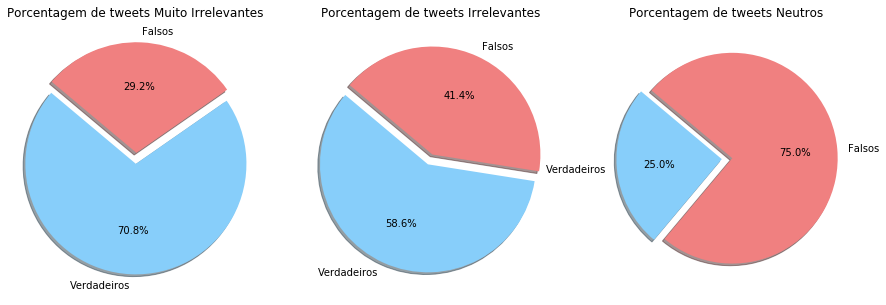

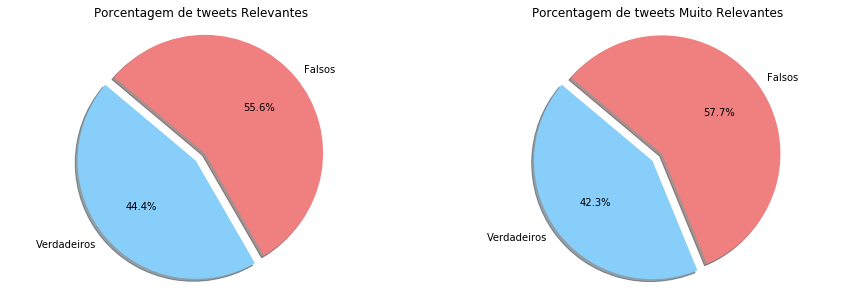

In [15]:
labels = 'Verdadeiros', 'Falsos'
sizesMI = [porcentagem_MI_verdadeiro, porcentagem_MI_falso]
sizesI = [porcentagem_I_verdadeiro, porcentagem_I_falso]
sizesN = [porcentagem_N_verdadeiro, porcentagem_N_falso]
sizesR = [porcentagem_R_verdadeiro, porcentagem_R_falso]
sizesMR = [porcentagem_MR_verdadeiro, porcentagem_MR_falso]
colors = ['lightskyblue', 'lightcoral']
explode = (0.1, 0) 

fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.pie(sizesMI, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Porcentagem de tweets Muito Irrelevantes")

plt.subplot(132)
plt.pie(sizesI, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Porcentagem de tweets Irrelevantes")

plt.subplot(133)
plt.pie(sizesN, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Porcentagem de tweets Neutros")
plt.show()

fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.pie(sizesR, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Porcentagem de tweets Relevantes")

plt.subplot(122)
plt.pie(sizesMR, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Porcentagem de tweets Muito Relevantes")
plt.show()

Após a devida aplicação do classificador Naive Bayes na base de dados contendo os tweets de teste, obtivemos um cenário no qual cerca de 70% do tweets muito irrelevantes são corretamente descartados, porém, quando se observa o comportamento obtido pelas demais categorias de relevância, os resultados não seriam satisfatórios caso esta fosse a versão final do programa utilizado pelo clinte. Isto é, na fase atual, o classificador acaba por retornar uma considerável porcentagem de tweets muito relevantes falsos (~57.7%); o que acabaria por voltar a atenção do marketing da empresa para mensagens que, na realidade, não mereceriam tamanho crédito.

A fim de contornar a margem de erros até então apresentada, alguns incrementos podem ser implementados. Por exemplo, atualmente nosso projeto nao reconhece frases sarcásticas e nem aquelas com cunho de dupla negação. Dessa forma, a frase "eu amo o Uber" será classificada com mesma relevância, independente se a pretensão do autor foi transmitir ou não sarcasmo. Além disso, uma frase do gênero "eu não odeio uber" possivelmente obteria uma relevância similar a que "eu odeio uber" ou "eu não gosto de uber" obteriam, e não ao que intrinsecamente a mensagem significaria - "eu amo uber". A consequência de ambos exemplos ocorrem pois o classificador analisa de forma independente a aprobabilidade condicional de cada palavra do tweet sendo analisado. Logo, uma versão refinada do programa, deveria, durante a execução de seu código, atentar-se a tais aspectos.

Devemos nos atentar ao fato de que o programa aqui implementado foi treinado como uma ínfima base de tweets e, consequentemente, de palavras, gerando assim uma taxa de acertos relativamente baixa, como pode ser observado no gráfico a seguir.  

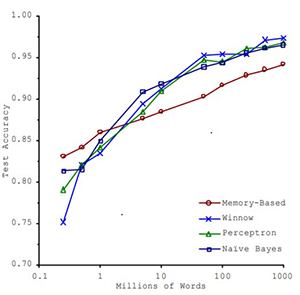
###### http://www.aclweb.org/anthology/P01-1005

Por conseguinte, o cliente deve continuar financiando nosso projeto para que tenhamos recursos para expandir nossa base de treinamento, assim como, atualizá-la sazonalmente (uma vez que, principalmente no meio cibernético, palavras e expressões tornam-se mais utilizadas de acordo com o contexto em questão e as tendências vigentes).  Tal investimento seria retornado para a empresa através de dados classificados com alta precisão, os quais poderiam ser utilizados para direcionar suas estratégias de marketing a potenciais clientes, defender sua reputação de tweets difamatórios e ainda atuar de forma acurada na resolução de problemas de seus usuários. 

*Ressalta-se que não podemos alimentar nossa base inicial de dados com os tweets posteriormente classificados por nosso programa, tendo em vista que tais apresentam erros sistemáticos e residuais de classificação - como citado anteriormente - que se propagariam, piorando assim, a confiabilidade da classificação de tweets futuros.

Embora o projeto aqui apresentado retrate uma temática específica, ou seja, análise das repercussões de um produto/serviço na rede social Twitter, o classificador Naive-Bayes poderia muito bem ser aplicado a diferentes cenários. Por exemplo, em um contexto político, ele poderia retornar a popularidade ou rejeição de determinado candidato, e, em um âmbito social, poderia elencar as dificuldades e problemas enfrentados por determinadas grupos. 
